## Agent Supervisor

The [previous example](multi-agent-collaboration.ipynb) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

![diagram](./img/supervisor-diagram.png)

To simplify the code in each agent node, we will use the AgentExecutor class from LangChain. This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

Before we build, let's configure our environment:

In [1]:
# %%capture --no-stderr
# %pip install -U langchain langchain_openai langchain_experimental langsmith pandas

In [2]:
import os
from dotenv import load_dotenv

# Carrega o arquivo .env que está na mesma pasta que o script
load_dotenv()

# Verifica se as variáveis de ambiente estão definidas e pede ao usuário caso não estejam
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Please provide your {var}")

# Checa e solicita as chaves API se necessário
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")

# Configurações opcionais
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Test Multi-agent"

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [3]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def sum_numbers(
    a: Annotated[int, "First number to be added."],
    b: Annotated[int, "Second number to be added."]
) -> Annotated[int, "Result of sum the two numbers."]:
    """Sums two numbers and returns the result."""
    return a + b

@tool
def subtract_numbers(
    a: Annotated[int, "First number from which the second number will be subtracted."],
    b: Annotated[int, "Second number to be subtracted from the first number."]
) -> Annotated[int, "Result of subtracting the second number from the first number."]:
    """Subtracts the second number from the first number and returns the result."""
    return a - b

## Helper Utilities

Define a helper function below, which make it easier to add new agent worker nodes.

In [4]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

We can also define a function that we will use to be the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [5]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Subtracao", "Soma"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-3.5-turbo")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [7]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


simple_sub_calculator = create_agent(llm, [subtract_numbers], "Calcule a diferença dois números fornecidos.")
sub_node = functools.partial(agent_node, agent=simple_sub_calculator, name="Subtracao")

simple_sum_calculator = create_agent(llm, [sum_numbers], "Calcule a soma dos números fornecidos.")
sum_node = functools.partial(agent_node, agent=simple_sum_calculator, name="Soma")

workflow = StateGraph(AgentState)
workflow.add_node("Subtracao", sub_node)
workflow.add_node("Soma", sum_node)
workflow.add_node("supervisor", supervisor_chain)

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

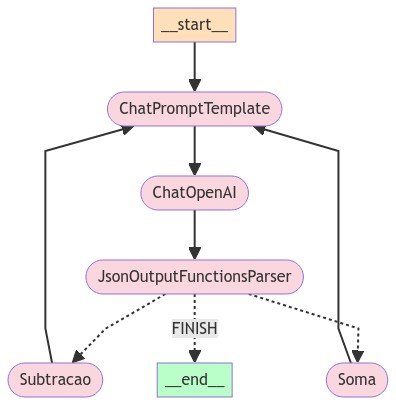

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [10]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Quanto é 2 + 3")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Soma'}}
----
{'Soma': {'messages': [HumanMessage(content='A soma de 2 + 3 é igual a 5.', name='Soma')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [11]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Quanto é 2 - 3")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Subtracao'}}
----
{'Subtracao': {'messages': [HumanMessage(content='A diferença entre 2 e 3 é -1.', name='Subtracao')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [12]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Quanto é 2 + 3 e depois pegue esse resultado e reduza 3")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Soma'}}
----
{'Soma': {'messages': [HumanMessage(content='A soma de 2 + 3 é 5 e ao reduzir 3 desse resultado, obtemos 2.', name='Soma')]}}
----
{'supervisor': {'next': 'Subtracao'}}
----
{'Subtracao': {'messages': [HumanMessage(content='A diferença entre 5 e 3 é 2.', name='Subtracao')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
